# 信用卡詐欺偵測：替代分析方法 (Alternative Methods)

本筆記本示範在 `creditcard.csv` 上，除了基礎的邏輯回歸外，還可嘗試的多種方法：
- 監督式學習：隨機森林、邏輯回歸（類別權重）
- 非監督/半監督：Isolation Forest、Local Outlier Factor (LOF)
- 評估：混淆矩陣、Precision/Recall/F1、ROC-AUC、PR-AUC
- 解釋：SHAP 對隨機森林的重要度解讀

> 重點：此資料極度不平衡，Precision-Recall 與閾值調整比單看準確率更有意義。


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils.class_weight import compute_class_weight

import shap

pd.set_option('display.max_columns', None)

DATA_PATH = Path('creditcard.csv')
assert DATA_PATH.exists(), f"找不到資料檔案: {DATA_PATH.resolve()}"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
Non-Fraud    284315
Fraud           492
Name: count, dtype: int64


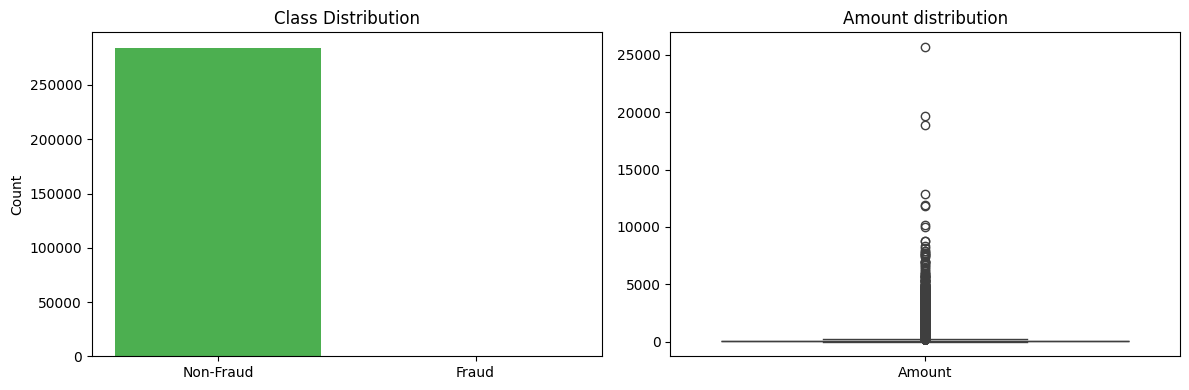

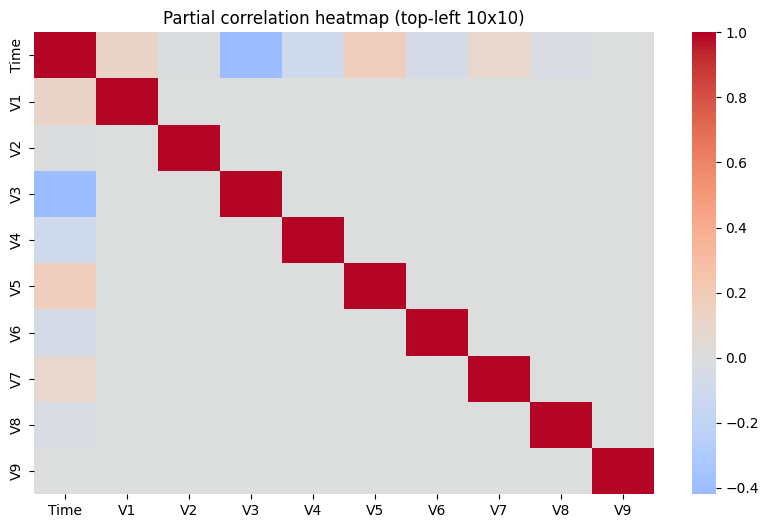

In [2]:
# EDA: 類別分佈與簡單統計
class_counts = df['Class'].value_counts().rename({0:'Non-Fraud', 1:'Fraud'})
print(class_counts)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].bar(class_counts.index.astype(str), class_counts.values, color=['#4CAF50', '#F44336'])
axes[0].set_title('Class Distribution')
axes[0].set_ylabel('Count')

sns.boxplot(data=df[['Amount']], ax=axes[1])
axes[1].set_title('Amount distribution')
plt.tight_layout()
plt.show()

corr = df.drop(columns=['Class']).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr.iloc[:10, :10], cmap='coolwarm', center=0)
plt.title('Partial correlation heatmap (top-left 10x10)')
plt.show()


In [3]:
# 資料切分與標準化
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)
print('Positive rate (train/test):', y_train.mean().round(5), y_test.mean().round(5))


Train size: (227845, 30) Test size: (56962, 30)
Positive rate (train/test): 0.00173 0.00172


In [4]:
# 工具：評估與繪圖函式
def evaluate_classifier(y_true, y_prob, threshold=0.5, title_prefix='Model'):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    print(f'{title_prefix} @ threshold={threshold}')
    print('ROC-AUC:', round(roc_auc, 5), '| PR-AUC (AP):', round(ap, 5))
    print('Confusion Matrix:\n', cm)
    print('Classification Report:\n', report)

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    axes[0].plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
    axes[0].plot([0,1],[0,1],'--', color='gray')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].legend()

    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    axes[1].plot(recall, precision, label=f'AP={ap:.3f}')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # 回傳方便後續比較
    return {
        'threshold': threshold,
        'roc_auc': roc_auc,
        'pr_auc': ap,
        'confusion_matrix': cm,
        'classification_report': report
    }


def tune_threshold_by_recall(precision, recall, thresholds, target_recall=0.8):
    # 找到達到指定 recall 的最低閾值
    idx = np.where(recall[:-1] >= target_recall)[0]
    if len(idx) == 0:
        return 0.5
    best = idx[-1]
    return float(thresholds[best])


Logistic (balanced) @ threshold=0.5
ROC-AUC: 0.97208 | PR-AUC (AP): 0.71897
Confusion Matrix:
 [[55478  1386]
 [    8    90]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962



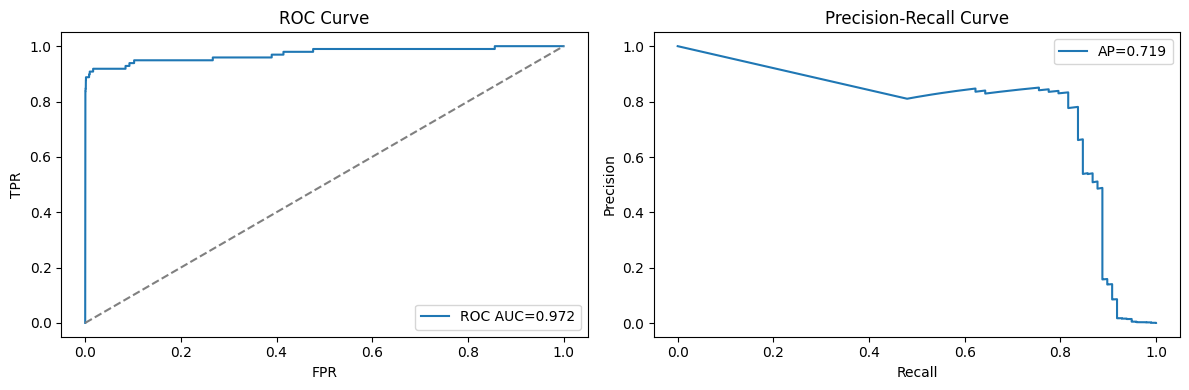

Threshold for ~80% recall: 0.9999999832105831
Logistic @ ~80% recall @ threshold=0.9999999832105831
ROC-AUC: 0.97208 | PR-AUC (AP): 0.71897
Confusion Matrix:
 [[56848    16]
 [   19    79]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8316    0.8061    0.8187        98

    accuracy                         0.9994     56962
   macro avg     0.9156    0.9029    0.9092     56962
weighted avg     0.9994    0.9994    0.9994     56962



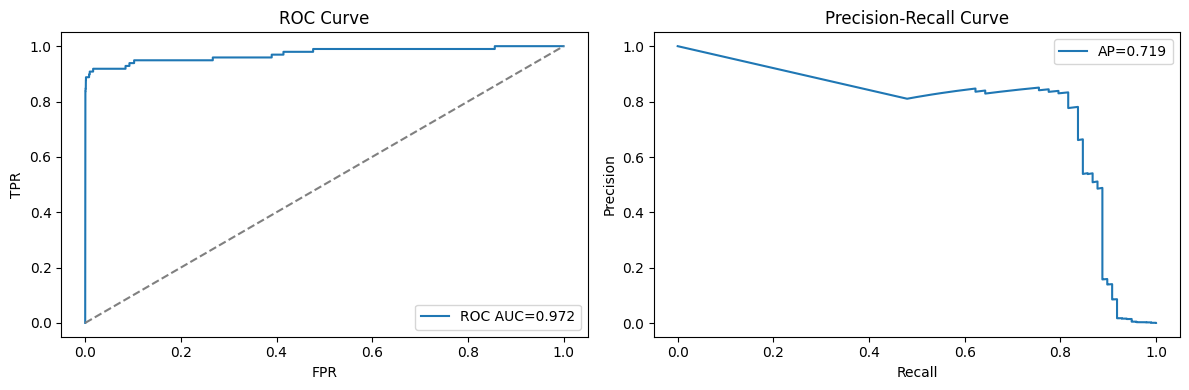

In [5]:
# 監督式學習：邏輯回歸（類別權重）
log_reg = LogisticRegression(max_iter=200, class_weight='balanced', solver='lbfgs', n_jobs=None)
log_reg.fit(X_train_scaled, y_train)

log_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
metrics_log = evaluate_classifier(y_test, log_prob, threshold=0.5, title_prefix='Logistic (balanced)')

# 可依目標 recall 調整 threshold
prec, rec, thr = precision_recall_curve(y_test, log_prob)
thr_80 = tune_threshold_by_recall(prec, rec, thr, target_recall=0.80)
print('Threshold for ~80% recall:', thr_80)
metrics_log_80 = evaluate_classifier(y_test, log_prob, threshold=thr_80, title_prefix='Logistic @ ~80% recall')


RandomForest (balanced) @ threshold=0.5
ROC-AUC: 0.95145 | PR-AUC (AP): 0.86224
Confusion Matrix:
 [[56860     4]
 [   23    75]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9494    0.7653    0.8475        98

    accuracy                         0.9995     56962
   macro avg     0.9745    0.8826    0.9236     56962
weighted avg     0.9995    0.9995    0.9995     56962



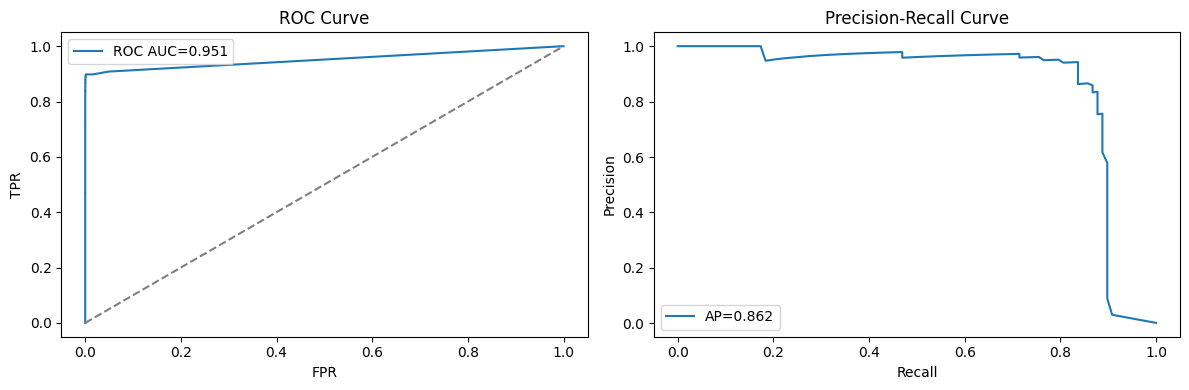

RF Threshold for ~80% recall: 0.37666666666666665
RandomForest @ ~80% recall @ threshold=0.37666666666666665
ROC-AUC: 0.95145 | PR-AUC (AP): 0.86224
Confusion Matrix:
 [[56859     5]
 [   19    79]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9405    0.8061    0.8681        98

    accuracy                         0.9996     56962
   macro avg     0.9701    0.9030    0.9340     56962
weighted avg     0.9996    0.9996    0.9996     56962



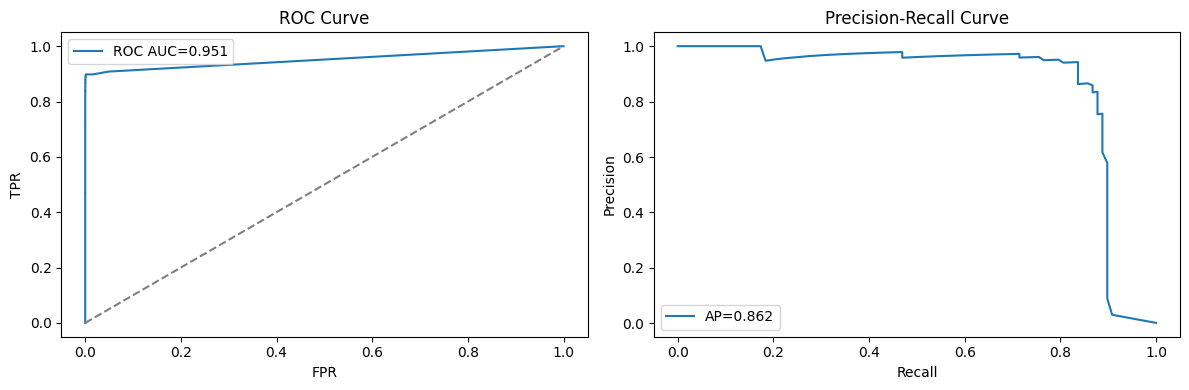

In [6]:
# 監督式學習：隨機森林（類別權重）
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

rf_prob = rf.predict_proba(X_test)[:, 1]
metrics_rf = evaluate_classifier(y_test, rf_prob, threshold=0.5, title_prefix='RandomForest (balanced)')

prec_rf, rec_rf, thr_rf = precision_recall_curve(y_test, rf_prob)
thr_rf_80 = tune_threshold_by_recall(prec_rf, rec_rf, thr_rf, target_recall=0.80)
print('RF Threshold for ~80% recall:', thr_rf_80)
metrics_rf_80 = evaluate_classifier(y_test, rf_prob, threshold=thr_rf_80, title_prefix='RandomForest @ ~80% recall')


IsolationForest @ threshold=0.7502491561688046
ROC-AUC: 0.95305 | PR-AUC (AP): 0.17035
Confusion Matrix:
 [[56793    71]
 [   70    28]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9988    0.9988    0.9988     56864
           1     0.2828    0.2857    0.2843        98

    accuracy                         0.9975     56962
   macro avg     0.6408    0.6422    0.6415     56962
weighted avg     0.9975    0.9975    0.9975     56962



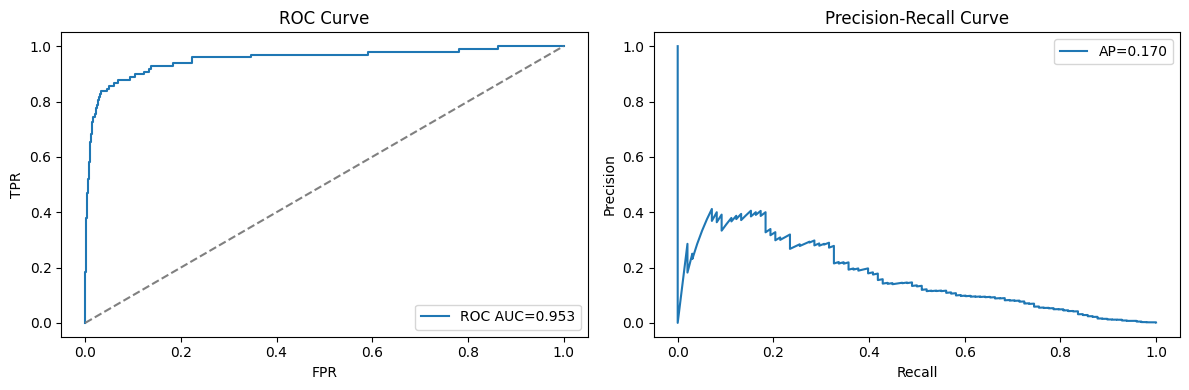

In [7]:
# 非監督/半監督：Isolation Forest
# 設定 contamination 為估計的詐欺比例（可用訓練集正例比例）
contam = float(y_train.mean())
iso = IsolationForest(
    n_estimators=300,
    contamination=contam,
    random_state=42,
    n_jobs=-1
)
iso.fit(X_train)

# IsolationForest 的 decision_function 值越大越正常；這裡我們取負號當作疑似詐欺的分數
iso_score = -iso.decision_function(X_test)
# 將分數線性縮放到 [0,1] 以利比較
iso_prob = (iso_score - iso_score.min()) / (iso_score.max() - iso_score.min() + 1e-9)

metrics_iso = evaluate_classifier(y_test, iso_prob, threshold=np.quantile(iso_prob, 1-contam), title_prefix='IsolationForest')


c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF @ threshold=0.1921851953750392
ROC-AUC: 0.68795 | PR-AUC (AP): 0.00627
Confusion Matrix:
 [[56767    97]
 [   96     2]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9983    0.9983    0.9983     56864
           1     0.0202    0.0204    0.0203        98

    accuracy                         0.9966     56962
   macro avg     0.5093    0.5094    0.5093     56962
weighted avg     0.9966    0.9966    0.9966     56962



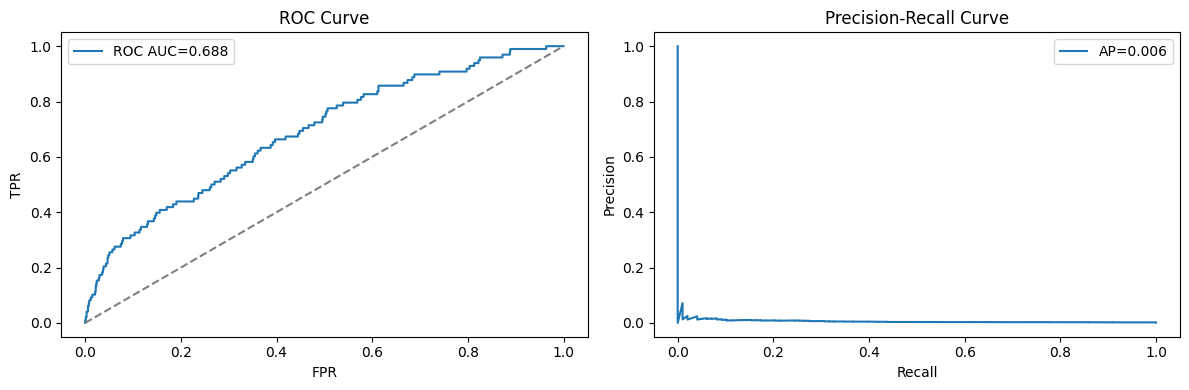

In [8]:
# 非監督/半監督：Local Outlier Factor (LOF)
# 使用 novelty=True 以便在測試集上打分
lof = LocalOutlierFactor(n_neighbors=35, novelty=True, contamination=contam, n_jobs=-1)
lof.fit(X_train)

lof_score = -lof.decision_function(X_test)
lof_prob = (lof_score - lof_score.min()) / (lof_score.max() - lof_score.min() + 1e-9)

metrics_lof = evaluate_classifier(y_test, lof_prob, threshold=np.quantile(lof_prob, 1-contam), title_prefix='LOF')


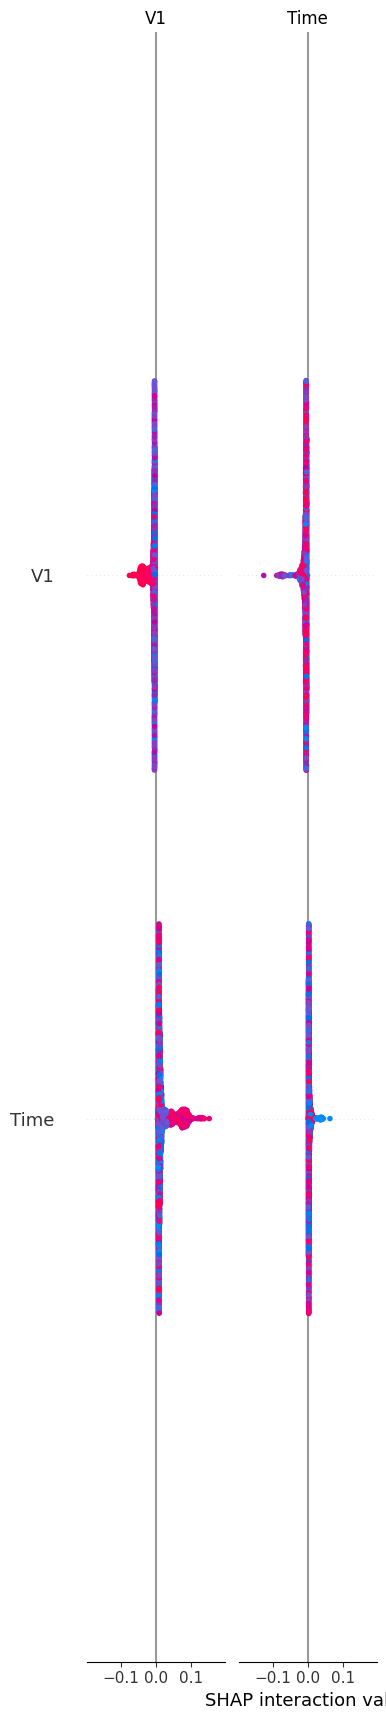

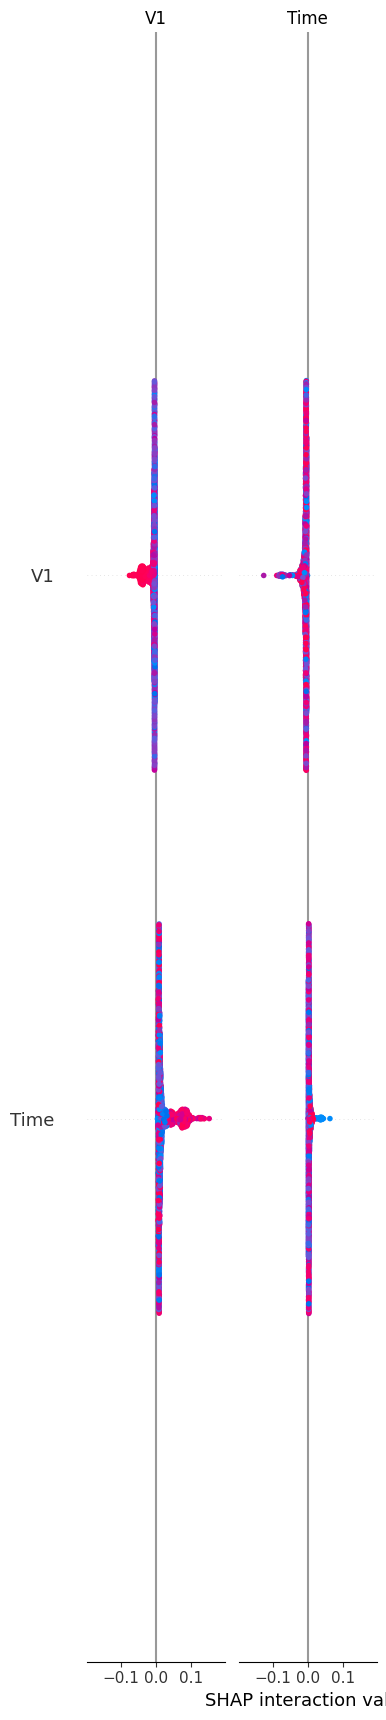

In [ ]:
# SHAP：解釋隨機森林的重要度（取樣以節省時間）
# 注意：在高維且資料量大時，SHAP 可能較耗時
explainer = shap.TreeExplainer(rf)
# 取部分測試資料以加速
sample_idx = np.random.RandomState(42).choice(len(X_test), size=min(2000, len(X_test)), replace=False)
X_sample = X_test.iloc[sample_idx]
shap_values = explainer.shap_values(X_sample)

# 兼容不同 SHAP 版本的輸出格式
if isinstance(shap_values, list):
    shap_arr = shap_values[1]
else:
    shap_arr = shap_values
# 某些版本會多一個偏置(常數)欄位，需去除
if shap_arr.shape[1] == X_sample.shape[1] + 1:
    shap_arr = shap_arr[:, :-1]

# 顯示前 20 個特徵的重要度摘要圖
shap.summary_plot(shap_arr, X_sample, plot_type='bar', max_display=20)
shap.summary_plot(shap_arr, X_sample, max_display=20)


In [11]:
# 結果彙整比較表
from collections import OrderedDict

rows = []
rows.append({'Model':'Logistic (0.5)', 'ROC-AUC': metrics_log['roc_auc'], 'PR-AUC': metrics_log['pr_auc']})
rows.append({'Model':'Logistic (~80%R)', 'ROC-AUC': metrics_log_80['roc_auc'], 'PR-AUC': metrics_log_80['pr_auc']})
rows.append({'Model':'RF (0.5)', 'ROC-AUC': metrics_rf['roc_auc'], 'PR-AUC': metrics_rf['pr_auc']})
rows.append({'Model':'RF (~80%R)', 'ROC-AUC': metrics_rf_80['roc_auc'], 'PR-AUC': metrics_rf_80['pr_auc']})
rows.append({'Model':'IsolationForest', 'ROC-AUC': metrics_iso['roc_auc'], 'PR-AUC': metrics_iso['pr_auc']})
rows.append({'Model':'LOF', 'ROC-AUC': metrics_lof['roc_auc'], 'PR-AUC': metrics_lof['pr_auc']})

summary_df = pd.DataFrame(rows)
display(summary_df.sort_values('PR-AUC', ascending=False).reset_index(drop=True))


,Model,ROC-AUC,PR-AUC
0,RF (~80%R),0.951453,0.862235
1,RF (0.5),0.951453,0.862235
2,Logistic (~80%R),0.972083,0.718971
3,Logistic (0.5),0.972083,0.718971
4,IsolationForest,0.953046,0.170352
5,LOF,0.687952,0.006274
